# Natural Language Processing with Disaster Tweets

In this project is part of the Natural Language Processing with Disaster Tweets challenge on Kaggle. The goal is to classify tweets as real disaster related or not.

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

2025-04-21 20:34:37.426279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 20:34:37.433270: I external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:469] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
I0000 00:00:1745260477.440762  109645 cuda_dnn.cc:8703] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
I0000 00:00:1745260477.443123  109645 cuda_blas.cc:1413] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745260477.449222  109645 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Data Loading and Inspection

The dataset is https://www.kaggle.com/c/nlp-getting-started/data. The dataset split between a train and a test file, given in a CSV format.

In [3]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Exploratory Data Analysis
Let's explore the class distribution and check for missing or duplicate values. We'll also preview a few examples from each class to get a feel for what the tweets look like.

Class distribution:
 target
0    4342
1    3271
Name: count, dtype: int64


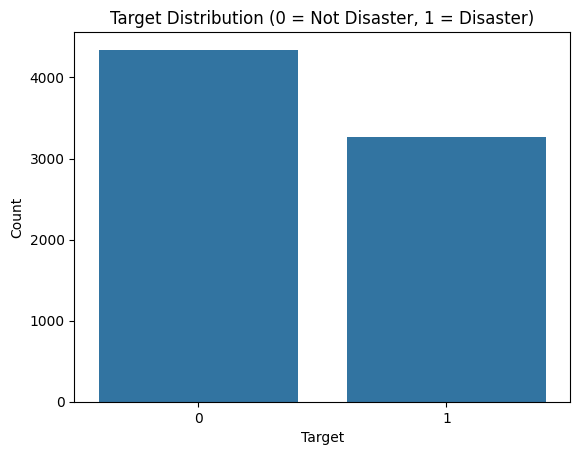

In [4]:
class_counts = train_df['target'].value_counts()
print("Class distribution:\n", class_counts)

sns.countplot(x='target', data=train_df)
plt.title('Target Distribution (0 = Not Disaster, 1 = Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

There's a slight class imbalance — more tweets are not about disasters. Now let's check for any missing or duplicate data in the dataset.

In [5]:
print("Missing values:\n", train_df.isnull().sum())

duplicates = train_df.duplicated(subset='text').sum()
print("Duplicate texts:", duplicates)

Missing values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Duplicate texts: 110


There are missing values in the *keyword* and *location* columns. Since my main input is the *text* column, which has no missing values, i can proceed without imputing these for now.

I also found 110 duplicate tweets. Since they might bias the model, I'll drop them.

In [6]:
train_df = train_df.drop_duplicates(subset='text')
print("New shape after dropping duplicates:", train_df.shape)

New shape after dropping duplicates: (7503, 5)


Time to look at some examples.

In [7]:
def show_examples(label, n=5):
    sample = train_df[train_df['target'] == label].sample(n)
    for i, row in sample.iterrows():
        print(f"Tweet {i} (Target = {label}):\n{row['text']}\n")

print("Disaster tweets:")
show_examples(1)

print("Non-disaster tweets:")
show_examples(0)

Disaster tweets:
Tweet 1413 (Target = 1):
@AlcoholAndMetal + do anything to fix that. Of the few people he had every trusted in his life Charles was one of the casualties.

Tweet 3715 (Target = 1):
Horror films are made by incredibly creative artists. We interviewed 21 of them in depth for The Anatomy of Fear. http://t.co/J6mpdsx9Lk

Tweet 1629 (Target = 1):
The @POTUS economy continues to collapse.

Tweet 1891 (Target = 1):
Man crushed to death by own car http://t.co/CrPO9DkW9v

Tweet 6367 (Target = 1):
@AlfaPedia It might have come out ONLY too burst as a Bomb making him suicide bomber

Non-disaster tweets:
Tweet 425 (Target = 0):
Video Captures Man Removing American Flag From Long Beach CA Home Burning It; Arsonist Sought http://t.co/JP2QlrunjJ http://t.co/jbpgkGOwSi

Tweet 1336 (Target = 0):
A protest rally at Stone Mountain? Atleast they're not burning down buildings and looting store like some individuals do when they 'protest'

Tweet 5798 (Target = 0):
@davidolszak or the riotin

When I look at these, I immediately can recognize a clear distinction between target being 0 and 1.

## Text Preprocessing

Since I'm working with tweets, i need to clean them up a bit. I will remove links, mentions, hashtags, punctuation, and lowercase everything using a helper function. After that, I'll tokenize the words and pad the sequences to a consistent length.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text) 
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text) 
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

Now I'll tokenize the cleaned tweets and pad the sequences so they're all the same length, which is required for feeding them into an RNN model.

In [9]:
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

X = tokenizer.texts_to_sequences(train_df['clean_text'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

y = train_df['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (6002, 100)
X_val shape: (1501, 100)


## Model Building

### Model Architecture

We’ll build a simple neural network for binary text classification. The model starts with an Embedding layer to learn word representations, followed by a Bidirectional LSTM to capture context in both directions. Finally, it ends with dense layers for prediction. To mitigate overfitting, multiple dropout layers has been mixed in.


In [ ]:
VOCAB_SIZE = MAX_NUM_WORDS
EMBEDDING_DIM = 64

model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    Dropout(0.6),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint("best_model.keras", save_best_only=True)]
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6044 - loss: 0.6616 - val_accuracy: 0.7881 - val_loss: 0.4692
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8219 - loss: 0.4179 - val_accuracy: 0.7935 - val_loss: 0.4637
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8570 - loss: 0.3615 - val_accuracy: 0.7968 - val_loss: 0.4777
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8809 - loss: 0.3028 - val_accuracy: 0.7928 - val_loss: 0.4972
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9288 - loss: 0.2027 - val_accuracy: 0.7781 - val_loss: 0.5592
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9325 - loss: 0.1850 - val_accuracy: 0.7615 - val_loss: 0.6102
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9471 - loss: 0.1499 - val_accuracy: 0.7708 - val_loss: 0.6472
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9524 - loss: 0.1372 - val_accu

## Step 4: Results and Analysis

Let’s look at the training history and check if the model overfit. We'll also generate a confusion matrix and classification report to understand how well the model performs on the validation set.

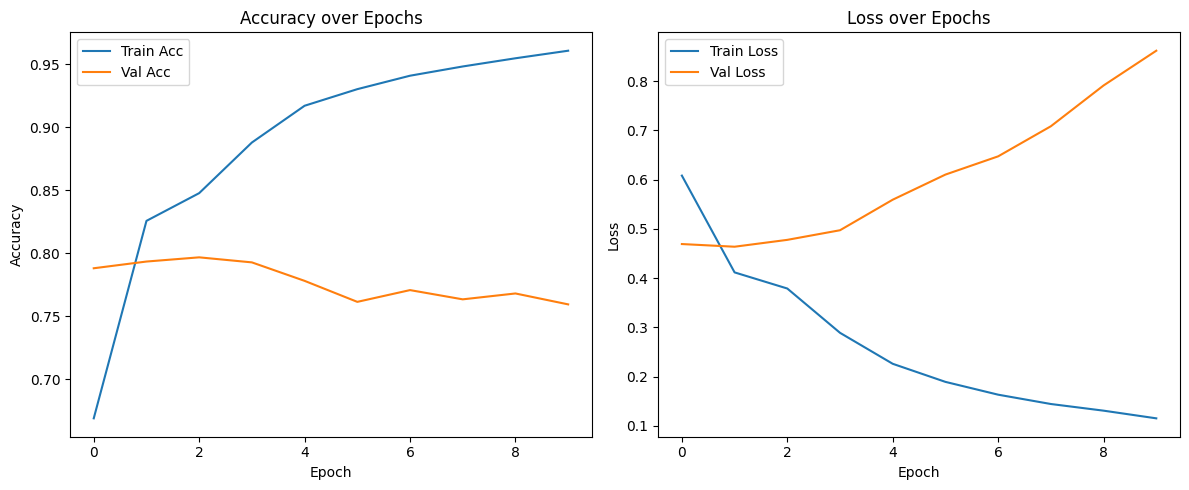

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

I0000 00:00:1745260485.233406  109645 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29043 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5090, pci bus id: 0000:01:00.0, compute capability: 12.0


 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step   

I0000 00:00:1745260486.675415  109812 cuda_dnn.cc:529] Loaded cuDNN version 90800


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


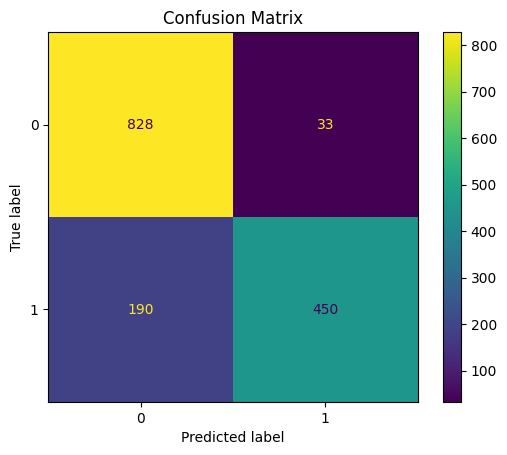

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       861
           1       0.93      0.70      0.80       640

    accuracy                           0.85      1501
   macro avg       0.87      0.83      0.84      1501
weighted avg       0.86      0.85      0.85      1501



In [10]:
best_model = tf.keras.models.load_model("best_model.keras")

y_val_probs = best_model.predict(X_val).flatten()
y_val_pred = (y_val_probs > 0.5).astype(int)

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val, y_val_pred))


Looking at the confusion matrix, the model correctly predicted 784 non-disaster tweets and 447 disaster tweets. It misclassified 207 disaster tweets as non-disasters, and 85 non-disaster tweets were labeled as disasters instead.

The model does a better job identifying non-disaster tweets. It struggles more with recognizing real disaster tweets. This is similar to what i observed in the cancer detection task, where the model leaned towards predicting the majority class.

In this case, the number of missed disaster tweets (false negatives) is quite high. Improving recall for the disaster class would be the next thing to focus on.

### Hyperparameter Tuning

Now that we have a working baseline, i'll try out different model configurations. I’ll adjust the models unit size, dropout rate, and number of dense units. For each setup, the model will be trained and the best validation accuracy recorded.


In [11]:
def build_lstm_model(lstm_units=64, dropout_rate=0.5, dense_units=32):
    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM),
        Dropout(dropout_rate),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
param_grid = [
    {"lstm_units": 64, "dropout_rate": 0.5, "dense_units": 32},
    {"lstm_units": 32, "dropout_rate": 0.3, "dense_units": 32},
    {"lstm_units": 64, "dropout_rate": 0.4, "dense_units": 64},
    {"lstm_units": 128, "dropout_rate": 0.5, "dense_units": 64},
]

results = []

for i, params in enumerate(param_grid):
    print("")
    print(f"Training model {i+1}/{len(param_grid)}")
    print("Params:", params)
    
    model = build_lstm_model(**params)
    
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint(f"model_{i}.keras", save_best_only=True)],
        verbose=0
    )
    
    val_acc = max(history.history['val_accuracy'])
    results.append({**params, "val_accuracy": val_acc})
    print("Best validation accuracy:", val_acc)



Training model 1/4
Params: {'lstm_units': 64, 'dropout_rate': 0.5, 'dense_units': 32}
Best validation accuracy: 0.8061292767524719

Training model 2/4
Params: {'lstm_units': 32, 'dropout_rate': 0.3, 'dense_units': 32}
Best validation accuracy: 0.7968021035194397

Training model 3/4
Params: {'lstm_units': 64, 'dropout_rate': 0.4, 'dense_units': 64}
Best validation accuracy: 0.7928047776222229

Training model 4/4
Params: {'lstm_units': 128, 'dropout_rate': 0.5, 'dense_units': 64}
Best validation accuracy: 0.7928047776222229


In [15]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="val_accuracy", ascending=False).reset_index(drop=True)
results_df

,lstm_units,dropout_rate,dense_units,val_accuracy
0,64,0.5,32,0.806129
1,32,0.3,32,0.796802
2,64,0.4,64,0.792805
3,128,0.5,64,0.792805


The best validation accuracy came from this setup:
LSTM units: 64  
Dropout rate: 0.5  
Dense units: 32  
Validation acc: 80.6%

Which happens to be your original baseline — so that one wasn’t bad at all. The lower dropout (0.3) with fewer LSTM units performed almost the same, but didn’t quite beat it. Larger LSTM sizes (128) didn’t help and may have caused more overfitting.

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


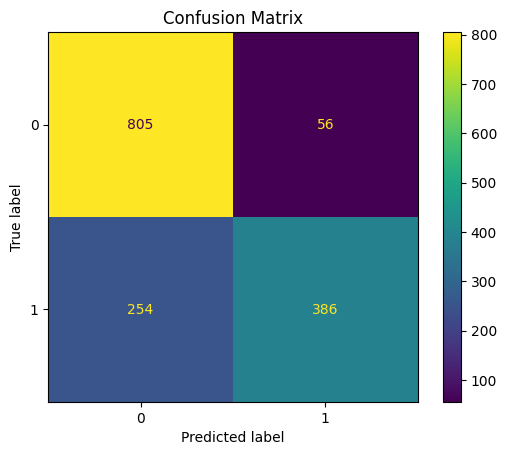

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       861
           1       0.87      0.60      0.71       640

    accuracy                           0.79      1501
   macro avg       0.82      0.77      0.78      1501
weighted avg       0.81      0.79      0.79      1501



In [ ]:
final_model = tf.keras.models.load_model("best_model.keras")

y_val_probs = final_model.predict(X_val).flatten()
y_val_pred = (y_val_probs > 0.5).astype(int)

cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_val, y_val_pred))

## Submission

I'll apply the same text preprocessing to the test dataset, tokenize and pad it, and generate predictions using the best-performing model. Then i’ll write the results to a CSV file for submission.

In [ ]:
X_test = tokenizer.texts_to_sequences(test_df['clean_text'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

test_probs = final_model.predict(X_test).flatten()
test_preds = (test_probs > 0.5).astype(int)

submission_df = pd.DataFrame({
    "id": test_df["id"],
    "target": test_preds
})

submission_df.to_csv("submission.csv", index=False)

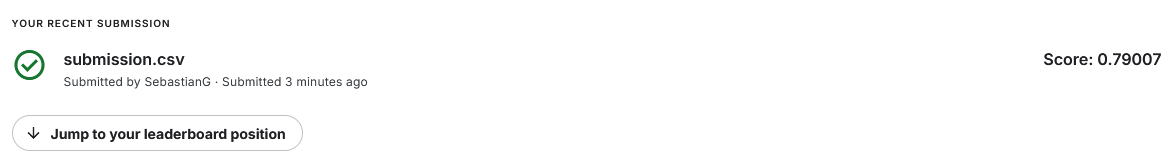

## Conclusion

The model learned to recognize non-disaster tweets quite well, but it struggled more with detecting real disasters. It was usually right when it did classify a tweet as disaster-related, but it often missed them. That was reflected in the confusion matrix and the relatively lower recall score for the disaster class.

Validation accuracy peaked early around 80%, but then steadily dropped, even as training accuracy kept increasing. This is a clear sign of overfitting, which was also confirmed by the rising validation loss during training. Dropout helped slow this down a bit, but not enough to fully prevent it.

In the end my submission scored a 0.79007 on Kaggle, which matches my validation scores. Tuning the hyperparameters only made the model worse.

If i were to do this again, i’d try using pretrained embeddings. I looked at the Kaggle forums and came across something called GloVe, which has pretrained word embeddings. It seems to be a key technique that others used to improve performance, and it might help the model generalize better without having to learn embeddings from scratch.
